# Overview of analysis

The objective of this notebook is to explore the dataset `ratings.csv`. The dataset contains the columns `userId, movieId, timestamp` containing items that are rated by the users and also timestamps. 

The notebook shows common ways to explore the dataset such as: 
1. Understanding User behaviour on a population level (frequent watchers, occasional watchers) by looking at distribution of number of movies watched by users. 


2. Understanding types of Movies (popular vs unpopular movies) through distribution of most watched movies


3. Frequent itemsets that often occur together which can be extended to explore a simple yet intuitive approach of modeling a recommender system

In [1]:
import os 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

ROOT = os.getenv('ROOT_FOLDER')
df = pd.read_csv(os.path.join(ROOT, "app/resources/rating.csv"), usecols=['userId', 'movieId', 'timestamp'])
df = df.assign(timestamp=pd.to_datetime(df.timestamp))

In [2]:
df.head()

,userId,movieId,timestamp
0,1,2,2005-04-02 23:53:47
1,1,29,2005-04-02 23:31:16
2,1,32,2005-04-02 23:33:39
3,1,47,2005-04-02 23:32:07
4,1,50,2005-04-02 23:29:40


### Descriptive stats

In [3]:
print(f"Number of users: {df.userId.unique().shape[0]}")
print(f"Number of movies: {df.movieId.unique().shape[0]}")

Number of users: 138493
Number of movies: 26744


In [4]:
print(f"Time range for the dataset {df.timestamp.min()} to {df.timestamp.max()}")

Time range for the dataset 1995-01-09 11:46:44 to 2015-03-31 06:40:02


###  User behaviour on a population level

This tells the behaviour of users on a population level. By understanding how many movies every user has watched we can divide the distribution on percentiles (25th, 50th, 95th) and each group of users can be used for modeling in someway 

1. 5 groups of users where each group has different characteristic (frequent watchers, occasional watchers, and those who rarely watch)
2. 95% users have watched 520 movies or less
3. There is a very strong group of 5% (6917) of users in the dataset who have watched more than 520 movies
4. Probably these will influence the dataset and recommendations heavily


In [5]:

movie_distribution = df.groupby('userId').agg({'movieId':'nunique'}).rename(columns={'movieId':'UserMovieCounts'})

In [6]:
movie_distribution.describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95])

,UserMovieCounts
count,138493.000000
mean,144.413530
std,230.267257
min,20.000000
5%,21.000000
25%,35.000000
50%,68.000000
75%,155.000000
95%,520.000000
max,9254.000000


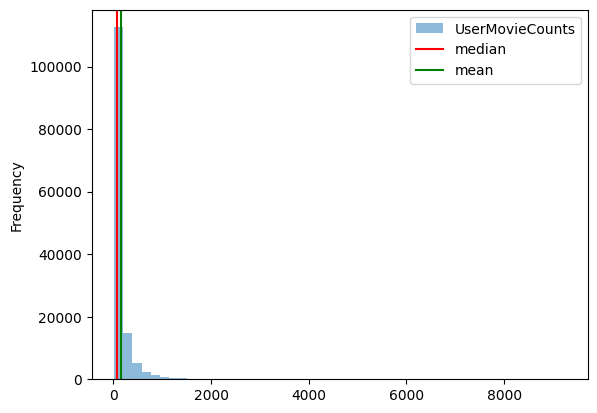

In [7]:
movie_distribution.reset_index(drop=True).plot.hist(bins=50, alpha=0.50)
plt.axvline(x=movie_distribution.UserMovieCounts.median(), c='red', label='median')
plt.axvline(x=movie_distribution.UserMovieCounts.mean(), c='green', label='mean')
plt.legend()

<AxesSubplot: >

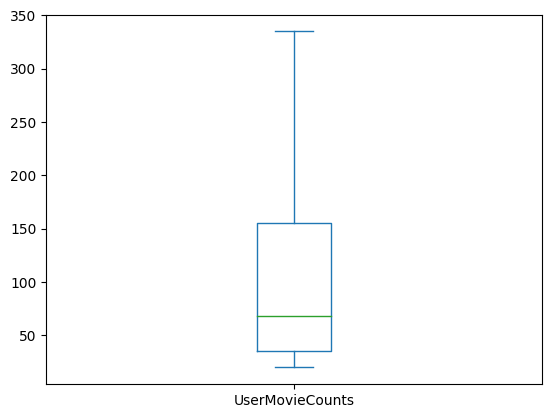

In [8]:
movie_distribution.reset_index(drop=True).plot.box(showfliers=False)

#### Find groups of users according to percentiles

In [9]:
percentiles = [0.0, 0.25, 0.50, 0.75, 0.95, 1.0]
labels = [f"{int(p*100)}%->{int(percentiles[i+1]*100)}%" 
          for i,p in enumerate(percentiles) if i<len(percentiles)-1]

user_groups = movie_distribution.assign(groups=pd.qcut(movie_distribution.UserMovieCounts, percentiles,labels))

user_groups = user_groups.set_index('groups', append=True).unstack(level='groups').droplevel(axis=1, level=0)

user_groups.head(10)

groups,0%->25%,25%->50%,50%->75%,75%->95%,95%->100%
userId,,,,,
1,NaN,NaN,NaN,175.0,NaN
2,NaN,61.0,NaN,NaN,NaN
3,NaN,NaN,NaN,187.0,NaN
4,28.0,NaN,NaN,NaN,NaN
5,NaN,66.0,NaN,NaN,NaN
6,24.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,276.0,NaN
8,NaN,NaN,70.0,NaN,NaN
9,35.0,NaN,NaN,NaN,NaN


<AxesSubplot: xlabel='groups'>

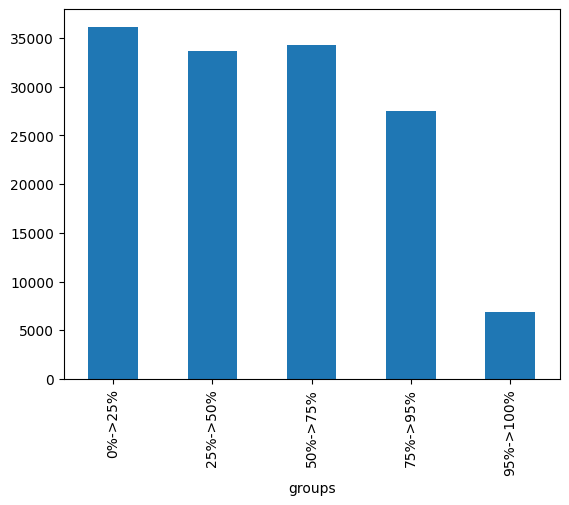

In [10]:
user_groups.count(axis=0).plot(kind='bar')

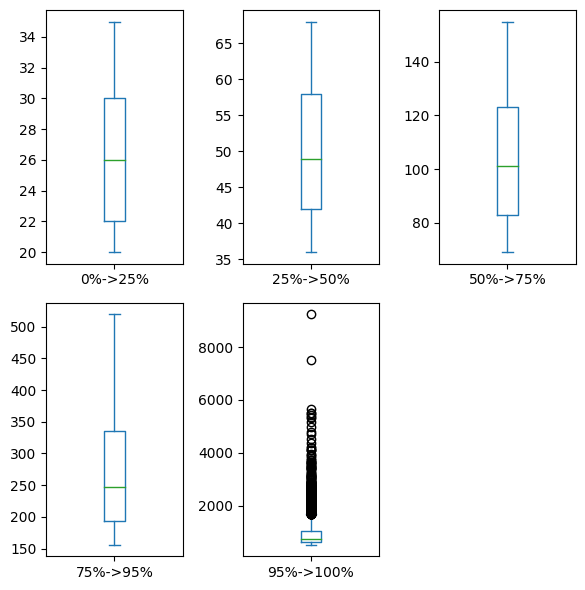

In [11]:
user_groups\
.plot(subplots=True, layout=(2, -1), figsize=(6, 6), sharex=False, kind='box')
plt.tight_layout()

### Popular movies in the dataset
This analysis will tell which movies are most commonly watched. We can extend this analysis to see which pair of movies occur most often. 

1. 50% of the movies have been watched by atleast 18 users i.e. only 0.012% of the users. So atleast half of the movies in the dataset are not so famous
2. 95% of the movies have been watched by atleast 3000 users or 2.16% of the users

In [12]:
user_distribution = df.groupby(['movieId']).agg({'userId':'nunique'}).rename(columns={'userId':'MovieUserCounts'})
user_distribution

,MovieUserCounts
movieId,
1,49695
2,22243
3,12735
4,2756
5,12161
...,...
131254,1
131256,1
131258,1


In [13]:
user_distribution.describe([0.05, 0.25, 0.50, 0.75, 0.95])

,MovieUserCounts
count,26744.000000
mean,747.841123
std,3085.818268
min,1.000000
5%,1.000000
25%,3.000000
50%,18.000000
75%,205.000000
95%,3612.950000
max,67310.000000


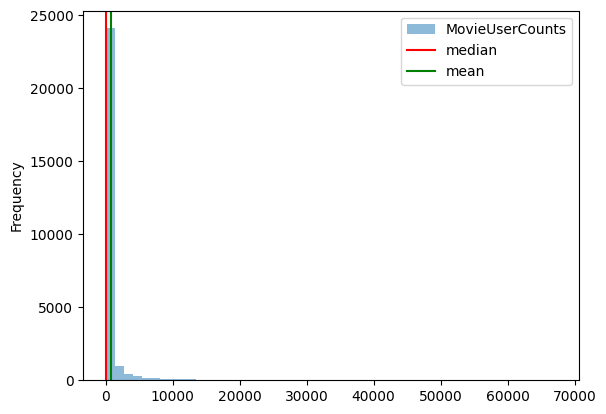

In [14]:
ax = user_distribution.reset_index(drop=True).plot.hist(bins=50, alpha=0.50, xlabel='unique number of users who watched the movie')
plt.axvline(x=user_distribution.MovieUserCounts.median(), c='red', label='median')
plt.axvline(x=user_distribution.MovieUserCounts.mean(), c='green', label='mean')
plt.legend()

#### Top 10 Most famous movies
1. movie 296 is the most famous movie that has been watched by 50% of the users. 

<AxesSubplot: xlabel='movieId'>

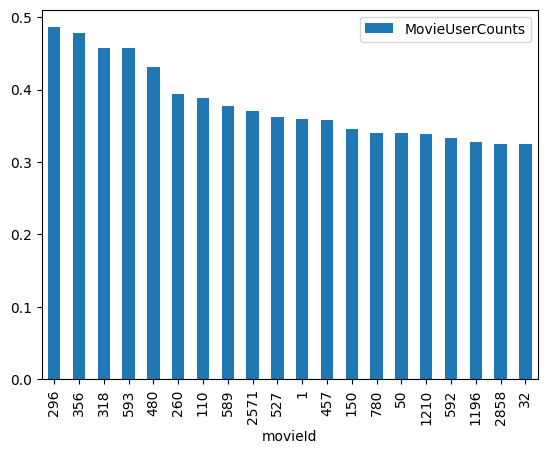

In [15]:
(user_distribution.sort_values('MovieUserCounts', ascending=False)/movie_distribution.shape[0])\
.head(20)\
.plot(kind='bar')

### Frequent itemsets of pairs of movies being watched together / Correlation among movies
To ease computation I have to restrict the sample space

1. Famous movie pairs are subset of movies i.e. top 5 most watched and 5 not movies not watched so often


If we think a very simple modeling approach I can say the probability of two contents being watched together most often is `probability(a given b)` i.e. probability that movie *`a`* will be watched given *`b`* has been already watched. This can be simply done by calculating conditional probab as follows:

`probab(a|b) = probab(a and b)/probab(b)`


*Drawbacks*
1. Problem with the above approach is that the famous movie pairs will be recommended always. i.e. most high scores will be taken by all popular movies  

2. This can be simply corrected by scaling the conditional probability by probability of watching recommended movie i.e. probability of *`a`*

`score(a) = probab(a|b)/probab(a)`

In [16]:
# popular movies + unpopular movies
movies_sample_space = user_distribution.sort_values('MovieUserCounts', ascending=False)[:5].index.tolist()+\
    user_distribution[user_distribution.MovieUserCounts<500].sort_values('MovieUserCounts').index[-5:].tolist()


user_sets = df[df.movieId.isin(movies_sample_space)].groupby('movieId').agg({'userId':'unique'})



In [17]:
%%time 

intersection = lambda s1,s2: (np.intersect1d(s1, s2).shape[0]/s2.shape[0])

conditional_probab = pd.DataFrame(
            [[intersection(user_sets.loc[movie1, 'userId'], user_sets.loc[movie2, 'userId']) 
              for movie1 in user_sets.index]
             for movie2 in user_sets.index
            ], 
    columns=user_sets.index, index=user_sets.index)




CPU times: user 243 ms, sys: 6.88 ms, total: 250 ms
Wall time: 249 ms


#####  How to read? 

`P(A|B) where A is the column index and B is the row index`

Example: 
`P(356|110) = 0.74` i.e. probability of watching movie 356 given that 110 has been already watched is 79%

**Remarks: This is not a symmetric matrix**

**Observations:** 
1. The top right side of the matrix has lower scores i.e. probability of watching an unpopular movie given that a popular movie has been watched is very low 

So that is probably why we need to rescale the scores so that the algorithm does not end up recommending only popular content

<AxesSubplot: xlabel='movieId', ylabel='movieId'>

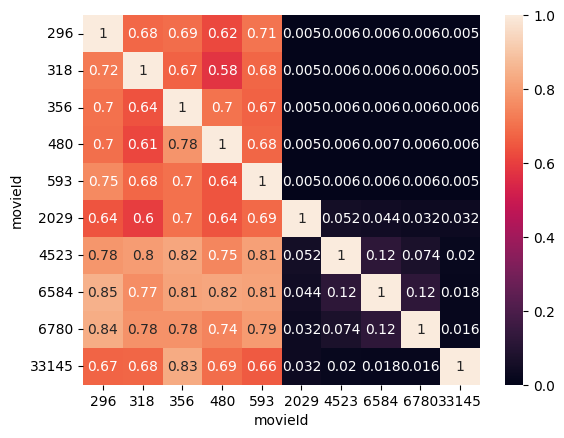

In [18]:

sns.heatmap(conditional_probab.round(decimals=3), annot=True, vmax=1.0, vmin=0.000)

####  Recorrecting the scores by scaling the probabilities 

In [19]:
probab_next_content = user_distribution.loc[conditional_probab.columns, 'MovieUserCounts']/df.userId.unique().shape[0]
probab_next_content

movieId
296      0.486017
318      0.457539
356      0.477800
480      0.431177
593      0.457056
2029     0.003603
4523     0.003603
6584     0.003596
6780     0.003596
33145    0.003603
Name: MovieUserCounts, dtype: float64

In [20]:
scores_rescaled = conditional_probab.divide(probab_next_content, axis=1)

<AxesSubplot: xlabel='movieId', ylabel='movieId'>

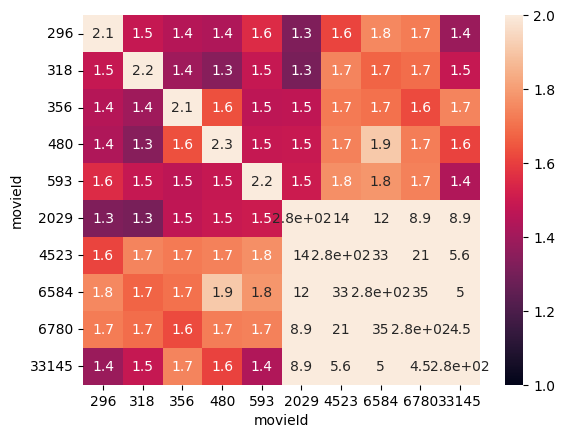

In [21]:

sns.heatmap(scores_rescaled.round(decimals=3), annot=True, vmax=2, vmin=1)

### Popularity of movies by time

In [22]:
popular_movies = user_distribution.sort_values('MovieUserCounts', ascending=False).index[:20]

In [23]:
ts = df[df.movieId.isin(popular_movies)]\
        .set_index('timestamp')\
        .groupby('movieId')\
        .resample('1M')\
        .size()\
        .unstack(level=0)



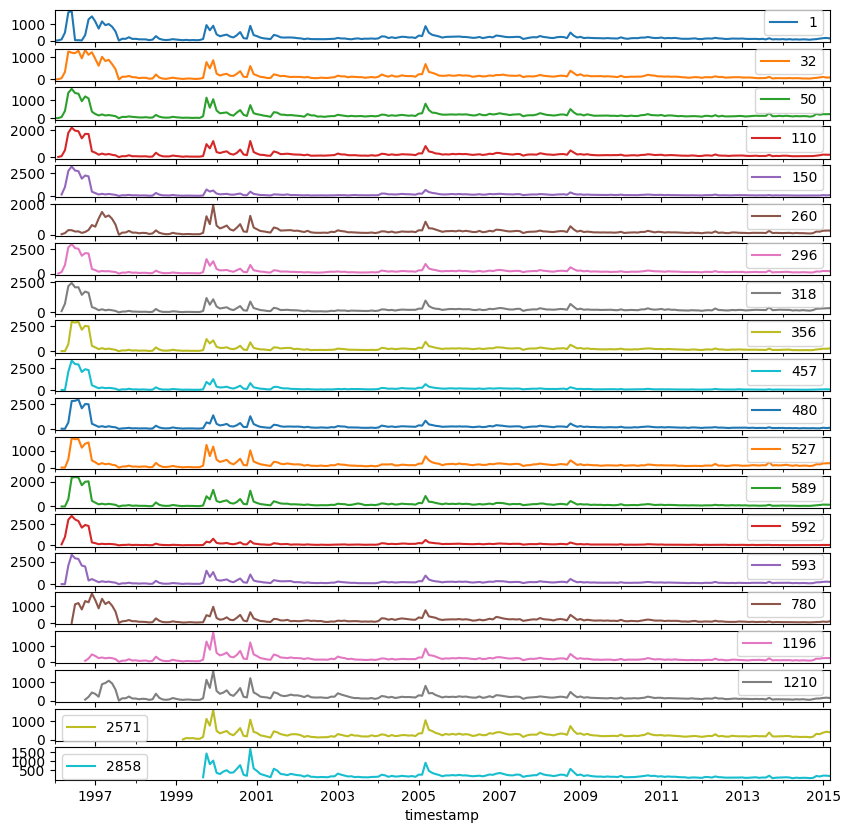

In [24]:
ax = ts.plot(figsize=(10,10), subplots=True, sharex=True, sharey=False)
